Shape initiale: (86064, 79)
Colonnes sélectionnées: 31
Shape après sélection: (86064, 31)
Shape après suppression doublons: (86064, 31)
Shape après filtrage prix: (54381, 31)
Features utilisées: 52
Échantillons finaux: 54381
=== RÉGRESSION LINÉAIRE ===
R² Score: 0.4042
RMSE: 117.27

=== RANDOM FOREST ===
R² Score: 0.5572
RMSE: 101.10

=== TOP 15 FEATURES LES PLUS IMPORTANTES ===
                           feature  importance
5                         bedrooms    0.304976
3                         latitude    0.085695
4                        longitude    0.081067
22                 amenities_count    0.056802
6                   minimum_nights    0.051806
21            host_experience_days    0.043145
20      host_response_time_encoded    0.043128
11               reviews_per_month    0.033964
1             host_acceptance_rate    0.023886
7           maximum_nights_avg_ntm    0.022630
17  calculated_host_listings_count    0.019581
15                availability_365    0.018317
26     

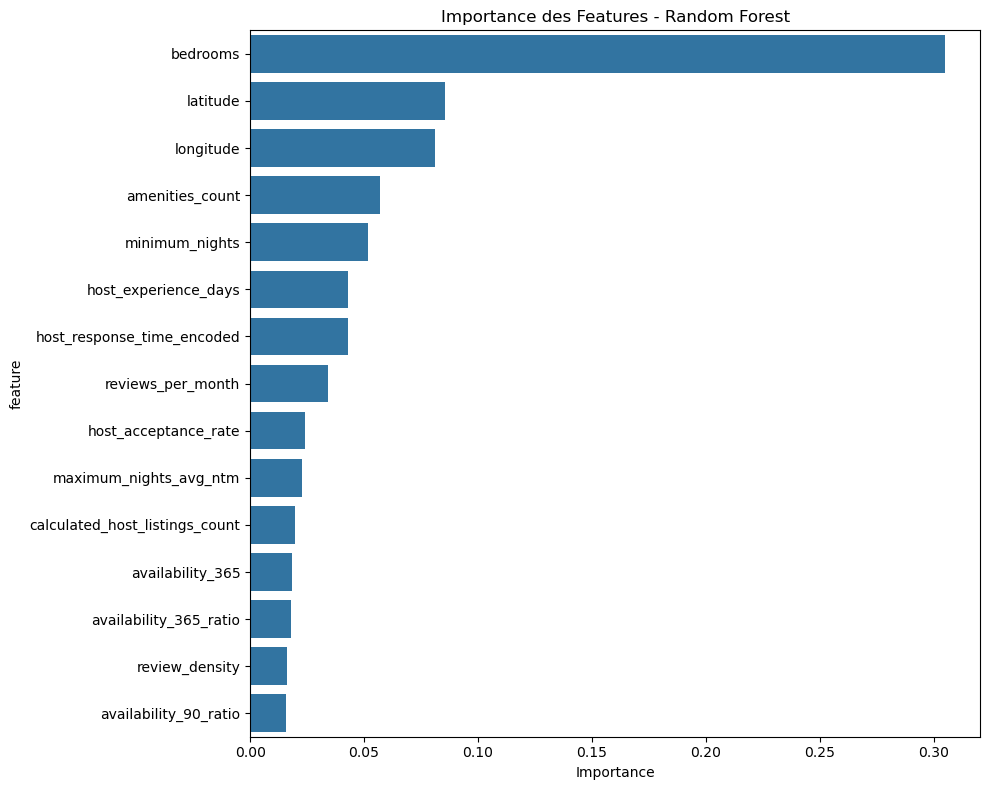

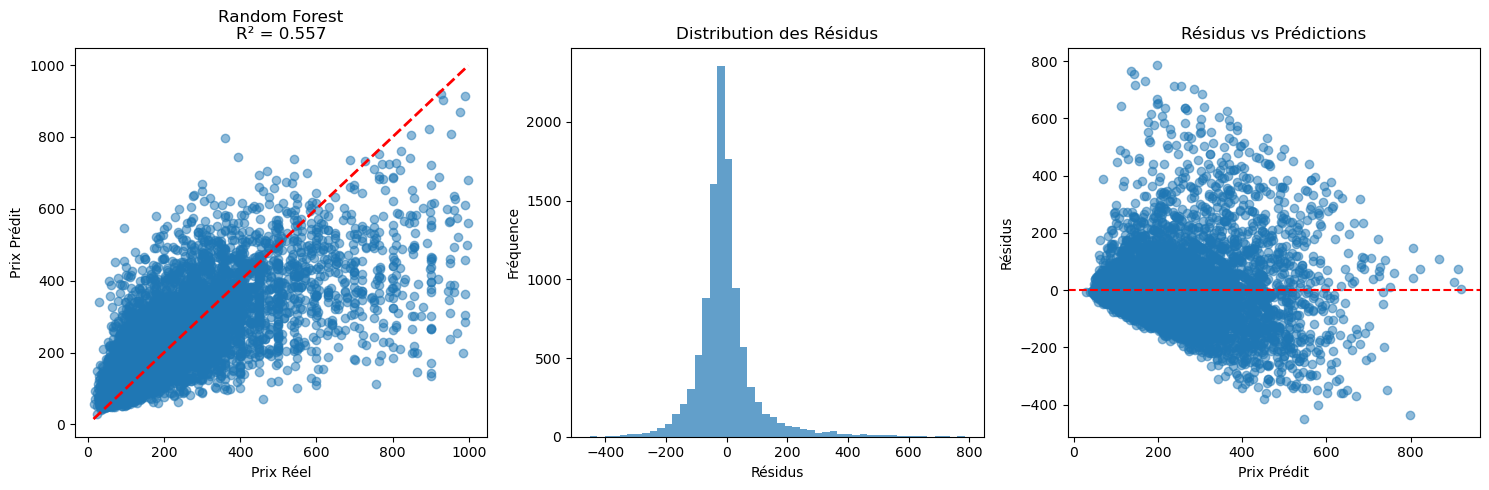


=== RÉSUMÉ ===
Amélioration du R² : 0.5572 vs 0.10 (original)
Réduction RMSE : 101.10 vs 92.92 (original)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import re

# Chargement du fichier
df = pd.read_csv('listings.csv')
print(f"Shape initiale: {df.shape}")

# Sélection des colonnes les plus pertinentes pour prédire le prix
colonnes_utiles = [
    'id', 'name', 'host_id', 'host_since', 'host_response_time', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
    'neighbourhood_cleansed', 'latitude', 'longitude',
    'room_type', 'bedrooms', 'amenities',
    'minimum_nights', 'maximum_nights_avg_ntm',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'reviews_per_month',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'instant_bookable',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'price'
]

# Garder seulement les colonnes qui existent
colonnes_existantes = [col for col in colonnes_utiles if col in df.columns]
df = df[colonnes_existantes]

print(f"Colonnes sélectionnées: {len(colonnes_existantes)}")
print(f"Shape après sélection: {df.shape}")

# ===== NETTOYAGE DES DONNÉES =====

# Supprimer les doublons
df = df.drop_duplicates()
print(f"Shape après suppression doublons: {df.shape}")

# Nettoyage du prix
if 'price' in df.columns:
    df['price'] = df['price'].astype(str).str.replace(r'[\$,]', '', regex=True)
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Filtrer les prix aberrants
df = df[(df['price'] > 10) & (df['price'] < 1000)]
print(f"Shape après filtrage prix: {df.shape}")

# ===== FEATURE ENGINEERING =====

# 1. Traitement des taux d'hôte (pourcentages)
for col in ['host_response_rate', 'host_acceptance_rate']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Encodage host_response_time
if 'host_response_time' in df.columns:
    response_time_mapping = {
        'within an hour': 1,
        'within a few hours': 2, 
        'within a day': 3,
        'a few days or more': 4
    }
    df['host_response_time_encoded'] = df['host_response_time'].map(response_time_mapping)

# 3. Expérience de l'hôte (en jours depuis inscription)
if 'host_since' in df.columns:
    df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
    df['host_experience_days'] = (pd.Timestamp.now() - df['host_since']).dt.days

# 4. Nombre d'équipements
if 'amenities' in df.columns:
    df['amenities_count'] = df['amenities'].astype(str).apply(lambda x: len(x.split(',')) if x != 'nan' else 0)

# 5. Variables de disponibilité relatives
for col in ['availability_30', 'availability_60', 'availability_90', 'availability_365']:
    if col in df.columns:
        days = int(col.split('_')[1])
        df[f'{col}_ratio'] = df[col] / days

# 6. Activité récente de l'annonce
if 'number_of_reviews_ltm' in df.columns and 'number_of_reviews' in df.columns:
    df['recent_reviews_ratio'] = df['number_of_reviews_ltm'] / (df['number_of_reviews'] + 1)

# 7. Densité de reviews
if 'first_review' in df.columns and 'last_review' in df.columns:
    df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['review_period_days'] = (df['last_review'] - df['first_review']).dt.days
    df['review_density'] = df['number_of_reviews'] / (df['review_period_days'] + 1)

# ===== GESTION DES VALEURS MANQUANTES =====

# Remplir les valeurs manquantes avec des valeurs sensées
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'price':
        if 'rate' in col or 'ratio' in col:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(0)

# Variables booléennes
if 'host_is_superhost' in df.columns:
    df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0)

if 'instant_bookable' in df.columns:
    df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0}).fillna(0)

# ===== ENCODAGE DES VARIABLES CATÉGORIELLES =====

# Room type
if 'room_type' in df.columns:
    df = pd.get_dummies(df, columns=['room_type'], prefix='room', drop_first=True)

# Neighbourhood (garder seulement les plus fréquents pour éviter trop de dimensions)
if 'neighbourhood_cleansed' in df.columns:
    top_neighbourhoods = df['neighbourhood_cleansed'].value_counts().head(20).index
    df['neighbourhood_top'] = df['neighbourhood_cleansed'].apply(
        lambda x: x if x in top_neighbourhoods else 'Other'
    )
    df = pd.get_dummies(df, columns=['neighbourhood_top'], prefix='neighbourhood', drop_first=True)

# ===== PRÉPARATION DES DONNÉES POUR LE MODÈLE =====

# Colonnes à exclure pour X
colonnes_a_exclure = ['id', 'name', 'host_id', 'price', 'host_since', 'first_review', 
                      'last_review', 'neighbourhood_cleansed', 'amenities', 'host_response_time']

X = df.drop([col for col in colonnes_a_exclure if col in df.columns], axis=1)
y = df['price']

# Supprimer les lignes avec des valeurs manquantes dans y
mask = ~y.isna()
X = X[mask]
y = y[mask]

print(f"Features utilisées: {X.shape[1]}")
print(f"Échantillons finaux: {X.shape[0]}")

# ===== MODÉLISATION =====

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Modèle de régression linéaire
print("=== RÉGRESSION LINÉAIRE ===")
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)

print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")

# 2. Random Forest (généralement plus performant pour ce type de données)
print("\n=== RANDOM FOREST ===")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=20)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")

# ===== ANALYSE DES FEATURES IMPORTANTES =====
if hasattr(model_rf, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== TOP 15 FEATURES LES PLUS IMPORTANTES ===")
    print(feature_importance.head(15))
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
    plt.title('Importance des Features - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# ===== VISUALISATION DES RÉSULTATS ===
plt.figure(figsize=(15, 5))

# Graphique 1: Prédictions vs Réalité (Random Forest)
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Prix Réel')
plt.ylabel('Prix Prédit')
plt.title(f'Random Forest\nR² = {r2_score(y_test, y_pred_rf):.3f}')

# Graphique 2: Distribution des résidus
plt.subplot(1, 3, 2)
residus = y_test - y_pred_rf
plt.hist(residus, bins=50, alpha=0.7)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Distribution des Résidus')

# Graphique 3: Résidus vs Prédictions
plt.subplot(1, 3, 3)
plt.scatter(y_pred_rf, residus, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prix Prédit')
plt.ylabel('Résidus')
plt.title('Résidus vs Prédictions')

plt.tight_layout()
plt.show()

print(f"\n=== RÉSUMÉ ===")
print(f"Amélioration du R² : {r2_score(y_test, y_pred_rf):.4f} vs 0.10 (original)")
print(f"Réduction RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f} vs {np.sqrt(8635.05):.2f} (original)")